<a href="https://colab.research.google.com/github/Arenaa/siamese-network/blob/main/Siamese_Network_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downlaod dataset
# **Microsoft Research Paraphrase Corpus**


In [3]:
!gdown  17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
!gdown  1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
!gdown  1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr

Downloading...
From: https://drive.google.com/uc?id=17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
To: /content/train.csv
100% 951k/951k [00:00<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
To: /content/valid.csv
100% 105k/105k [00:00<00:00, 92.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr
To: /content/test.csv
100% 444k/444k [00:00<00:00, 163MB/s]


# Import libraries


In [28]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, losses
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import to_categorical


# Preparing Dataset


In [4]:
train = pd.read_csv("/content/train.csv")
valid = pd.read_csv("/content/valid.csv")
test = pd.read_csv("/content/test.csv")

In [5]:
def clean_data(data):

  tokenized_data = []

  for d in data:
    tokens = d.split()
    translation_table = str.maketrans('', '', "\"#$%&'()*+,-/:;<=>?@[\]^_`{|}~،؟!❊#$٪^&*)(ـ+=-؛:{}")
    tokens = [w.translate(translation_table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokenized_data.append(tokens)

  return tokenized_data

In [6]:
length = []

for index, row in train.iterrows():
  length.append(len(row.sentence1.split(" ")))
  length.append(len(row.sentence2.split(" ")))

print(np.mean(length))

18.972063232488416


In [7]:
MAX_SEQ_LENGTH = 20

# clean data
cleaned_train_data = clean_data(train.sentence1.append(train.sentence2))
cleaned_valid_data = clean_data(valid.sentence1.append(valid.sentence2))
cleaned_test_data = clean_data(test.sentence1.append(test.sentence2))

# create the tokenizer and fit it on the input text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_data)

# tokenize the input text into encoded numbers
train_sequences = tokenizer.texts_to_sequences(cleaned_train_data)
valid_sequences = tokenizer.texts_to_sequences(cleaned_valid_data)
test_sequences = tokenizer.texts_to_sequences(cleaned_test_data)

# pad the input text 
train_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
valid_sequences = pad_sequences(valid_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

# separate sentence1 and sentence2
train_sent1 = train_sequences[:len(train)]
train_sent2 = train_sequences[len(train): len(train) * 2]
valid_sent1 = valid_sequences[:len(valid)]
valid_sent2 = valid_sequences[len(valid): len(valid) * 2]
test_sent1 = test_sequences[:len(test)]
test_sent2 = test_sequences[len(test): len(test) * 2]

<ipython-input-7-0f5545255bf0>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_train_data = clean_data(train.sentence1.append(train.sentence2))
<ipython-input-7-0f5545255bf0>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_valid_data = clean_data(valid.sentence1.append(valid.sentence2))
<ipython-input-7-0f5545255bf0>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_test_data = clean_data(test.sentence1.append(test.sentence2))


In [8]:
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) + 1
EMB_SIZE = 100

In [9]:
train_words = clean_data(train.sentence1.append(train.sentence2))

w2v_model = Word2Vec(train_words, min_count=1, vector_size=EMB_SIZE, window=3, sg=1)

words = list(w2v_model.wv.key_to_index.keys())
embeddings = w2v_model.wv.vectors

lines = []
for i in range(len(words)):
    line = words[i]
    for j in range(len(embeddings[i])):
        line += ' '
        line += str(embeddings[i][j])
    lines.append(line)

<ipython-input-9-3902b2bc69e3>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_words = clean_data(train.sentence1.append(train.sentence2))


In [11]:
embeddings_index = {}

embedding_matrix = np.random.random((VOCAB_SIZE, EMB_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Create Model

In [13]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="attention_bias", shape=(input_shape[1], 1), initializer="zeros")      

        super(Attention, self).build(input_shape)

    def call(self, x):

        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        # return K.sum(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [38]:
# define model
def get_model(VOCAB_SIZE, EMB_SIZE, MAX_SEQ_LENGTH, embedding_matrix):

  # define layers
  embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LENGTH, weights=[embedding_matrix], mask_zero=True, name='EmbeddingLayer')
  bilstm_layer = Bidirectional(LSTM(EMB_SIZE, dropout=0.2, activation="tanh", return_sequences=True, recurrent_dropout=0.5))
  att_layer = Attention()


  # sentence1
  sent1_input = Input(shape=(MAX_SEQ_LENGTH,), name='Sentence1')
  sent1_emb = embedding_layer(sent1_input)
  sent1_bilstm = bilstm_layer(sent1_emb)
  sent1_att = att_layer(sent1_bilstm)


  # sentence2
  sent2_input = Input(shape=(MAX_SEQ_LENGTH,), name='Sentence2')
  sent2_emb = embedding_layer(sent2_input)
  sent2_bilstm = bilstm_layer(sent2_emb)
  sent2_att = att_layer(sent2_bilstm)
  
 
  concat_layer = Concatenate(name='concatenate', axis=1)([sent1_att, sent2_att])
  flatten = Flatten()(concat_layer)

  drop_layer1 = Dropout(0.2)(flatten)
  dense_layer1 = Dense(512, activation='relu', name='DenseLayer1')(drop_layer1)
  dense_layer2 = Dense(128, activation='relu', name='DenseLayer2')(drop_layer1)
  dense_layer3 = Dense(64, activation='relu', name='DenseLayer3')(dense_layer2)
  dense_layer4 = Dense(32, activation='relu', name='DenseLayer4')(dense_layer3)
  drop_layer2 = Dropout(0.2)(dense_layer4)

  out = Dense(2, activation='softmax', name='OutputLayer')(drop_layer2)

  model = Model(inputs=[sent1_input, sent2_input], outputs=out)

  optimizer = optimizers.Adam(learning_rate=2e-4)
  loss = losses.binary_crossentropy

  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', Recall(), Precision()])

  return model

In [16]:
model = get_model(VOCAB_SIZE, EMB_SIZE, MAX_SEQ_LENGTH, embedding_matrix)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sentence1 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 Sentence2 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 20, 100)      1201700     ['Sentence1[0][0]',              
                                                                  'Sentence2[0][0]']              
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 200)      160800      ['EmbeddingLayer[0][0]',     

# Train model

In [19]:
y_train = np.array(to_categorical(train.label), dtype=int)
y_valid = np.array(to_categorical(valid.label), dtype=int)
y_test = np.array(to_categorical(test.label), dtype=int)

max_epoch = 7

In [20]:
siamese_model = model.fit(
    [train_sent1, train_sent2],
    y_train,
    validation_data = ([valid_sent1, valid_sent2], y_valid),
    epochs=max_epoch,
    verbose=1,
    batch_size=128,
)

Epoch 1/7
29/29 [==============================] - 40s 662ms/step - loss: 0.6438 - accuracy: 0.6620 - recall: 0.6620 - precision: 0.6620 - val_loss: 0.5909 - val_accuracy: 0.7174 - val_recall: 0.7174 - val_precision: 0.7174
Epoch 2/7
29/29 [==============================] - 18s 611ms/step - loss: 0.6143 - accuracy: 0.6708 - recall: 0.6708 - precision: 0.6708 - val_loss: 0.5869 - val_accuracy: 0.7174 - val_recall: 0.7174 - val_precision: 0.7174
Epoch 3/7
29/29 [==============================] - 16s 547ms/step - loss: 0.6117 - accuracy: 0.6708 - recall: 0.6708 - precision: 0.6708 - val_loss: 0.5940 - val_accuracy: 0.7174 - val_recall: 0.7174 - val_precision: 0.7174
Epoch 4/7
29/29 [==============================] - 14s 492ms/step - loss: 0.6109 - accuracy: 0.6708 - recall: 0.6708 - precision: 0.6708 - val_loss: 0.5984 - val_accuracy: 0.7174 - val_recall: 0.7174 - val_precision: 0.7174
Epoch 5/7
29/29 [==============================] - 17s 577ms/step - loss: 0.6121 - accuracy: 0.6708 - re

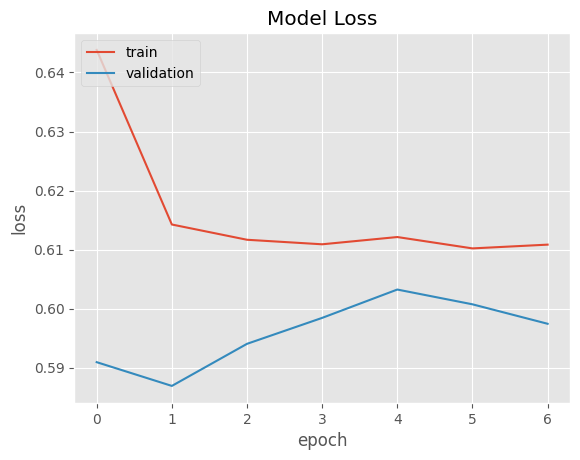

In [27]:
plt.style.use('ggplot')

plt.plot(siamese_model.history['loss'])
plt.plot(siamese_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test model

In [36]:
import warnings
warnings.filterwarnings('ignore')

predictions = model.predict([test_sent1, test_sent2])

pred_labels = [np.argmax(predictions[i]) for i in range(len(y_test))]

y_test = test.label.astype(int)

print(classification_report(y_test, pred_labels, target_names=['Class 0', 'Class 1'], zero_division='warn'))

54/54 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       578
     Class 1       0.66      1.00      0.80      1147

    accuracy                           0.66      1725
   macro avg       0.33      0.50      0.40      1725
weighted avg       0.44      0.66      0.53      1725



In [37]:
print("Test Accuracy:", accuracy_score(y_test, pred_labels)) 
print('Test Precision (micro):', precision_score(y_test, pred_labels, average='micro'))
print('Test Recall (micro):', recall_score(y_test, pred_labels, average='micro'))
print('Test F1 Score (micro):', f1_score(y_test, pred_labels, average='micro'))
print('Test Precision (macro):', precision_score(y_test, pred_labels, average='macro'))
print('Test Recall (macro):', recall_score(y_test, pred_labels, average='macro'))
print('Test F1 Score (macro):', f1_score(y_test, pred_labels, average='macro'))

Test Accuracy: 0.664927536231884
Test Precision (micro): 0.664927536231884
Test Recall (micro): 0.664927536231884
Test F1 Score (micro): 0.664927536231884
Test Precision (macro): 0.332463768115942
Test Recall (macro): 0.5
Test F1 Score (macro): 0.3993732590529248


In [45]:
data_index = 500
 
print("sentence1:")
print(test.sentence1[data_index])
print("sentence2:")
print(test.sentence2[data_index])
print("*************************")

sent1 = []
sent2 = []

for index in test_sent1[data_index]:
    if index == 0:
        sent1.append('PAD')
    else:
        sent1.append(tokenizer.index_word[index])

for index in test_sent2[data_index]:
    if index == 0:
        sent2.append('PAD')
    else:
        sent2.append(tokenizer.index_word[index])

print("prediction:", pred_labels[data_index])
print("true labels:", y_test[data_index])

sentence1:
The European Union was due Monday to demand Iran accept "urgently and unconditionally" tougher nuclear inspections and to link compliance with a pending trade deal.
sentence2:
The European Union was due on Monday to demand that Iran accept "urgently and unconditionally" tougher inspections of its nuclear program, linking compliance to a pending trade deal.
*************************
prediction: 1
true labels: 1
